# Dynamic linear models

In [1]:
import numpy as np
from numpy import linalg as la
import pandas as pd 
import LinearDynamic as lm
from scipy.stats import chi2
import seaborn as sns
sns.set_theme(); 

# ignore future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

np.set_printoptions(precision=5)
%load_ext autoreload
%autoreload 2

# Prepare the data

In this problem set, we consider the question of state dependence in **firm revenue** ($y$). The data, `cvr_extract.csv`, comes from the Danish register of firms, "CVR registret". It can be reconstructed or modified by downloading the tax files from [skst.dk](https://www.sktst.dk/aktuelt/skatteoplysninger-for-selskaber/) and running the notebook `clean_data.ipynb`. 

**Research question:** Should we provide assistance to firms? If the effects of adverse shocks (such as a pandemic) are very persistent, then we want to provide a safety net for firms. Conversely, if firms just rebound after a shock, that can be a waste of tax funds. 

The data consists of all firms observed in every year from 2012-2019, which satisfy that the net income (pre-tax) was below 10 mio. DKK. The variables in the data are: 

  |*Variable*  | *Content* |
  |------------| --------------------------------------------|
  |`net_inc`          | Net income (`income - deficit`) |
  |`taxable_income`          | Income |
  |`deficit`          | Losses |
  |`tax`          | Tax payment |
 | `cat`         | A categorical variable, based on the dummies, `dum_X` below |
  | `dum_X`          | Dummy for whether the firm's name contains the string `X` (in Danish) |
  
  The dummies, e.g. `dum_doctor`, are explained below 

| **Substring** | **If name contains** | 
| ---- | ------ | 
| `as` | 'a/s' | 
| `aps` | 'aps' | 
| `ivs` | 'ivs' | 
| `ab` | 'a/b' | 
| `realestate` | 'ejendom' | 
| `holding` | 'holding' | 
| `invest` | 'invest' | 
| `consult` | 'consult' | 
| `service` | 'service' | 
| `dot_dk` | '.dk' | 
| `doctor` | 'læge' | 
| `carpenter` | 'tømrer' | 
| `transport` | 'transport' or 'lastvogn' | 
| `plumbing` | 'vvs' or 'kloak' | 
| `import` | 'import' | 
| `masonry` | 'murer' | 
| `nielsen` | 'nielsen' | 
| `sorensen` | 'sørensen' | 

In [2]:
dat = pd.read_csv('cvr_extract.csv')
dat.sample(3)

,firmid,year,taxable_income,deficit,tax,net_inc,cat,dum_as,dum_aps,dum_ivs,...,dum_dot_dk,dum_doctor,dum_carpenter,dum_transport,dum_plumbing,dum_import,dum_masonry,dum_nielsen,dum_sorensen,dum_cars
80548,10068,2016,-23778.0,0.0,0.0,-23778.0,NaN,0,1,0,...,0,0,0,0,0,0,0,0,0,0
266724,33340,2016,205354.0,8545.0,45166.0,196809.0,nielsen,0,1,0,...,0,0,0,0,0,0,0,1,0,0
355876,44484,2016,44642.0,109709.0,9812.0,-65067.0,NaN,0,1,0,...,0,0,0,0,0,0,0,0,0,0


If you'd like a quick summary of your data, panda data frames have useful summary commands

In [3]:
dat.info() # returns number of elements, data type and column name for each column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 519416 entries, 0 to 519415
Data columns (total 26 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   firmid          519416 non-null  int64  
 1   year            519416 non-null  int64  
 2   taxable_income  519416 non-null  float64
 3   deficit         325538 non-null  float64
 4   tax             519415 non-null  float64
 5   net_inc         519416 non-null  float64
 6   cat             206143 non-null  object 
 7   dum_as          519416 non-null  int64  
 8   dum_aps         519416 non-null  int64  
 9   dum_ivs         519416 non-null  int64  
 10  dum_ab          519416 non-null  int64  
 11  dum_realestate  519416 non-null  int64  
 12  dum_holding     519416 non-null  int64  
 13  dum_invest      519416 non-null  int64  
 14  dum_consult     519416 non-null  int64  
 15  dum_service     519416 non-null  int64  
 16  dum_dot_dk      519416 non-null  int64  
 17  dum_doctor

In [4]:
dat.describe().round(2) # returns a number of summary stats (e.g. mean, max, count etc.) for each column

,firmid,year,taxable_income,deficit,tax,net_inc,dum_as,dum_aps,dum_ivs,dum_ab,...,dum_dot_dk,dum_doctor,dum_carpenter,dum_transport,dum_plumbing,dum_import,dum_masonry,dum_nielsen,dum_sorensen,dum_cars
count,519416.00,519416.00,519416.00,325538.00,519415.00,519416.00,519416.00,519416.00,519416.00,519416.00,...,519416.00,519416.00,519416.00,519416.00,519416.00,519416.00,519416.00,519416.00,519416.0,519416.00
mean,32463.00,2015.50,117339.59,86276.41,42206.91,63266.85,0.08,0.77,0.00,0.02,...,0.01,0.02,0.01,0.00,0.00,0.00,0.01,0.01,0.0,0.00
std,18742.83,2.29,733176.06,367100.49,144385.21,765531.91,0.27,0.42,0.01,0.13,...,0.11,0.13,0.08,0.06,0.07,0.03,0.07,0.10,0.0,0.06
min,0.00,2012.00,-9922979.00,0.00,-46318.00,-9922979.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00
25%,16231.00,2013.75,-11829.00,0.00,0.00,-56250.00,0.00,1.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00
50%,32463.00,2015.50,0.00,0.00,0.00,-4800.00,0.00,1.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00
75%,48695.00,2017.25,77523.75,33843.75,17512.00,59509.75,0.00,1.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00
max,64926.00,2019.00,14833306.00,17147427.00,3187492.00,9987792.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.0,1.00


In [5]:
# print table which can be copied to latex
print(dat.describe().round(2).to_latex(escape=False))

\begin{tabular}{lrrrrrrrrrrrrrrrrrrrrrrrrr}
\toprule
 & firmid & year & taxable_income & deficit & tax & net_inc & dum_as & dum_aps & dum_ivs & dum_ab & dum_realestate & dum_holding & dum_invest & dum_consult & dum_service & dum_dot_dk & dum_doctor & dum_carpenter & dum_transport & dum_plumbing & dum_import & dum_masonry & dum_nielsen & dum_sorensen & dum_cars \\
\midrule
count & 519416.000000 & 519416.000000 & 519416.000000 & 325538.000000 & 519415.000000 & 519416.000000 & 519416.000000 & 519416.000000 & 519416.000000 & 519416.000000 & 519416.000000 & 519416.000000 & 519416.000000 & 519416.000000 & 519416.000000 & 519416.000000 & 519416.000000 & 519416.000000 & 519416.000000 & 519416.000000 & 519416.000000 & 519416.000000 & 519416.000000 & 519416.000000 & 519416.000000 \\
mean & 32463.000000 & 2015.500000 & 117339.590000 & 86276.410000 & 42206.910000 & 63266.850000 & 0.080000 & 0.770000 & 0.000000 & 0.020000 & 0.030000 & 0.230000 & 0.060000 & 0.020000 & 0.010000 & 0.010000 & 0.020000 

# Descriptives

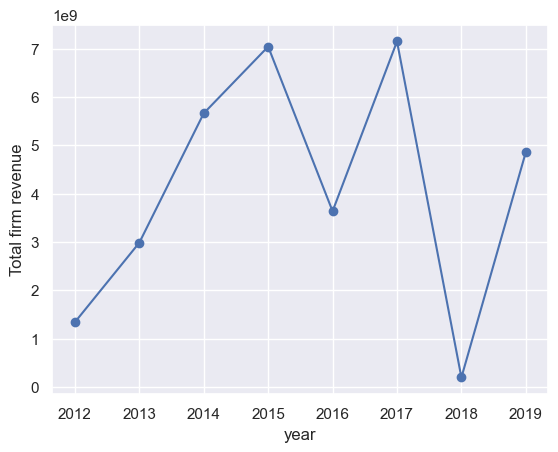

In [6]:
ax=dat.groupby('year').net_inc.sum().plot(marker='o'); 
ax.set_ylabel('Total firm revenue'); 

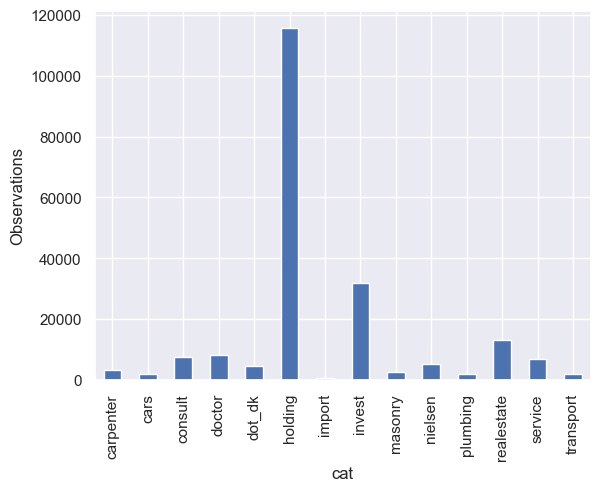

In [7]:
ax = dat.groupby('cat').taxable_income.count().plot(kind='bar'); 
ax.set_ylabel('Observations'); 

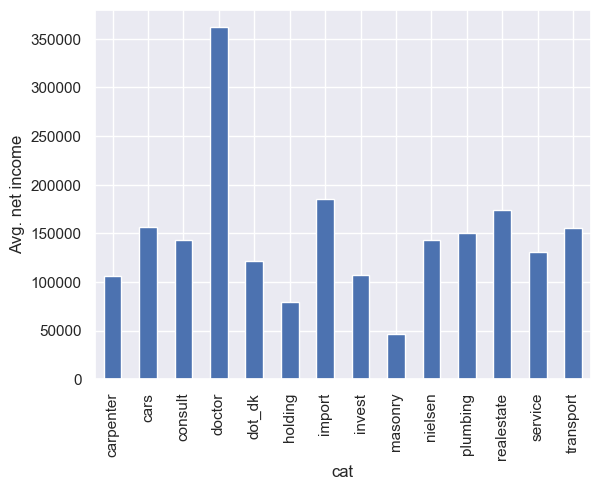

In [8]:
ax = dat.groupby('cat').taxable_income.mean().plot(kind='bar'); 
ax.set_ylabel('Avg. net income'); 

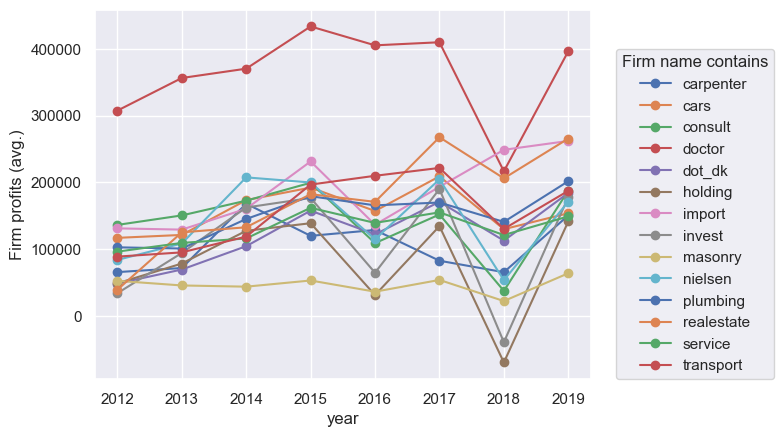

In [9]:
ax=dat.groupby(['year', 'cat']).taxable_income.mean().unstack().plot(marker='o'); 
ax.set_ylabel('Firm profits (avg.)'); 
ax.legend(title='Firm name contains', loc=(1.05,0.)); 

# Set up data

In [10]:
# Select only firms that are in real estate in all years 
I = dat.groupby('firmid').dum_realestate.transform('all') #<-- creates an indicator for real estate
dat = dat[I].copy() # <-- pulls out real estate firms

In [11]:
# convenient list of the names of all the dummy variables
cols_dum = [c for c in dat.columns if c == 'dum_']

# convert int->bool 
for c in cols_dum: 
    dat[c] = dat[c].astype('bool')

N = dat.firmid.unique().size
T = dat.year.unique().size
print(f'Data has {dat.shape[0]:,d} rows: N = {N:,d}, T = {T}')

Data has 14,272 rows: N = 1,784, T = 8


In [12]:
# measure money in 1000 DKK 
for v in ['net_inc', 'taxable_income', 'deficit', 'tax']: 
    dat[v] = dat[v] / 1000.

In [13]:
# lag net income using "shift" from pandas
dat['lag_net_inc']  = dat.groupby('firmid').net_inc.shift(1)
dat['lag2_net_inc'] = dat.groupby('firmid').net_inc.shift(2)

### Pandas to numpy 

In [14]:
# remove nans due to differencing
I = dat.lag_net_inc.notnull() # cannot use first year: no lagged variable 

T = dat[I].year.unique().size # NB this measure of T already has one year subtracted 
N = dat[I].firmid.unique().size

assert dat[I].shape[0] == N*T, 'Data is not a balanced panel'

In [15]:
# turn panda data frames into numpy arrays
y = dat[I].net_inc.values.reshape((-1,1))
y_l = dat[I].lag_net_inc.values.reshape((-1,1))

const = np.ones((N*T,1))
x = np.column_stack((const, y_l))

# labels
ylbl = 'profit'
xlbl = ['const', 'lagged profit']

# Part 1: POLS
Today we will focus on a parsimonious model of profit $\pi (econometricians often use "parsimonious" to mean a "simple"). 

Consider first the following AR(1) (autoregressive model of order $1$),

$$
\pi_{it} = \alpha_0 +  \rho \pi_{it-1} + c_i + u_{it}, \quad t = 1, 2, \dotsc, T \tag{1}
$$

As we have seen before, if one does not take into consideration $c_i$ when estimating $\rho$, one will get biased results. One way to solve this, which is also a common way for AR(1) processes, is to take first-differences. We then have the model,

$$
\Delta \pi_{it} = \rho \Delta \pi_{it-1} + \Delta u_{it}, \quad t = 2, \dotsc, T \tag{2}
$$

This solves the presence of fixed effects.

### Question 1.1
Estimate eq. (1) using POLS and robust standard errors (you'll need to adjust the `robust` function in `LinearDynamic_ante.py` first.)

*Note:* We need to use the lagged values of net income. But this time we don't need to lag it ourselves as it that has already been done above.

In [16]:
# Estimate the AR(1) model using OLS and robust standard errors
ar1_result = lm.estimate(y, x, robust_se=True, T=T)

# Print out in a nice table
lm.print_table((ylbl, xlbl), ar1_result, title='AR(1)', floatfmt=['', '.3f', '.5f', '.2f'])

AR(1)
Dependent variable: profit

                 Beta       Se    t-values
-------------  ------  -------  ----------
const          73.494  7.77624        9.45
lagged profit   0.517  0.03473       14.90
R² = 0.252
σ² = 476937.886


Your table should look like this:


AR(1)
Dependent variable: profit

|              |  Beta |     Se|   t-values | 
|------------- | ------|  -------|  ----------|
|const   |       73.494 | 7.77624 |      9.45|
|lagged profit |  0.517 | 0.03473  |     14.90| 
R² = 0.252
σ² = 476937.886

In [17]:
# in case you want results in a panda data frame
ar1_res=pd.DataFrame([ar1_result['b_hat'].flatten(), ar1_result['se'].flatten(),ar1_result['t_values'].flatten()], 
             index=['beta', 'se', 't'], columns=xlbl).T
ar1_res.round(2)


,beta,se,t
const,73.49,7.78,9.45
lagged profit,0.52,0.03,14.90


In [18]:
# or as a latex table
(ar1_res.round(2)).style.to_latex()


'\\begin{tabular}{lrrr}\n & beta & se & t \\\\\nconst & 73.490000 & 7.780000 & 9.450000 \\\\\nlagged profit & 0.520000 & 0.030000 & 14.900000 \\\\\n\\end{tabular}\n'

Questions:
* Are there signs of autocorrelation in profit?
* What assumptions are no longer satisfied? What happens with fixed effects when we include a lag?

### Question 1.2
Estimate eq. (2) using first differences. 
* What problem does this solve? 
* What type of exogeneity assumption is used to justify this method of estimation?

*Note 1:* You have to create the first differencing matrix yourself, and use the `perm` function to permutate the dependen and independent variables. <br>
*Note 2:* Use robust standard errors. 

In [19]:
# Create a first difference matrix
def fd(t):
    # Create a first difference matrix.
    D_t = np.eye(t, k=1) - np.eye(t)
    # We also remove the last row, so that we delete the first observation.
    return D_t[:-1]
D_t = fd(T)

In [20]:
# First difference both pi and lag of pi
yfd   = lm.perm(D_t, y)
yfd_l = lm.perm(D_t, y_l.reshape(-1, 1))

In [21]:
# Estimate AR(1) model using OLS with robust se and print a nice table
ar1_diff_result = lm.estimate(yfd, yfd_l, robust_se=True, T=T-1, transform='fd')
lm.print_table((ylbl, [xlbl[1]]), 
    ar1_diff_result, title='FD AR(1)', floatfmt=['', '.3f', '.4f', '.2f'])

FD AR(1)
Dependent variable: profit

                 Beta      Se    t-values
-------------  ------  ------  ----------
lagged profit  -0.412  0.0244      -16.89
R² = 0.167
σ² = 520184.128


Your table should look like this:

FD AR(1) <br>
Dependent variable: profit

|              |   Beta |     Se |   t-values |
|------------- | ------ | ------ | ---------- |
|lagged profit | -0.412 | 0.0244 |     -16.89 |
R² = 0.167
σ² = 520184.128

## Super short introduction to pooled IV (piv)

Suppose we want to estimate the effect of $x_K$ on $y$, conditional on $K - 1$ other controls, we then have the usual equation,

$$
\mathbf{y} = \mathbf{X} \boldsymbol{\beta} + \mathbf{u} \tag{3}
$$

where $\mathbf{X} = (\mathbf{x}_1, \dotsc, \mathbf{x}_K)$. If $\mathbf{x}_K$ is not exogenous, we can define the instrument vector $\mathbf{Z} = (\mathbf{x}_1, \dotsc, \mathbf{x}_{K - 1}, \mathbf{z}_1)$, where $\mathbf{z}_1$ is an instrument for $\mathbf{x}_K$. The details and necessary assumptions and conditions are outlined in Wooldridge (2010) (chapter 5).

We can estimate eq. (3) by OLS using $z_1$ as an instrument for $x_K$, in order to make it easier for you when writing code, I write it up in matrix notation,

$$
\boldsymbol{\hat{\beta}} = (\hat{\mathbf{X}}'\hat{\mathbf{X}})^{-1} \hat{\mathbf{X}}'\mathbf{Y}, \tag{4}
$$

where $\mathbf{\hat{X}} = \mathbf{Z}(\mathbf{Z'}\mathbf{Z})^{-1}\mathbf{Z'}\mathbf{X}$.

# Part 2: Pooled IV
It should not be a surprise that models (1) and (2) violate the strict exegoneity assumption but even if we relax this assumption to sequential exegoneity, the FD-estimator remains inconsistent.

A solution to this is to use an instrument for $\Delta \pi_{it-1}$. The biggest issue is to find an instrument that is not only relevant, but also exogenous.

We often use an additional lag as instruments. So for $\Delta \pi_{it-1}$, we can use $\pi_{it-2}$. In general, we have all possible lags available as instruments. So for $\Delta \pi_{it-1}$ we have, $
\pi_{it-2}^{\textbf{o}} = (\pi_{i0}, \pi_{i1}, \dotsc \pi_{it-2})$ available as instruments.

*Note:* $R^2$ has no meaning in IV-regressions, you can report it if you want to. But I set it to 0.

### Question 2.1
Estimate eq. (2) by using the lag of the independent variable in levels, $z_{it} = \pi_{it-2}$ as an instrument. You need to finish writing the `est_piv` function and a part of the `estimate` function in `LinearDynamic_ante`.

*Note 1:* In order to create the instrument, you need to create a lag matrix, and use `perm`. <br>
*Note 2:* In the `estimate` function, the `variance` function takes $\mathbf{X}$ as an argument. But we want to pass the `variance` function $\mathbf{\hat{X}}$ instead. You will need to adjust the estimate function and est_piv function in LinearDynamic(_ante).py <br>

In [22]:
# Create first a lag matrix
def lag(t):
    # Create a lag matrix.
    L_t = np.eye(t, k=-1)
    # Again remove the first observation, by removing the first row.
    return L_t[1:]
L_t = lag(T)

In [23]:
# Lag the lagged pi variable
# First lag yl, and then use it as an instrument for the lagged differences.
y_2l = lm.perm(L_t, y_l.reshape(-1, 1))

In [24]:
# Estimate using first differences and lagged first differences. Use the 2. lag as instrument.
ar1_iv_lvl_result = lm.estimate(yfd, yfd_l, y_2l, robust_se=True, T=T-1)

lm.print_table(
    (ylbl, [xlbl[1]]), 
    ar1_iv_lvl_result, title='FD-IV AR(1)', floatfmt=['', '.3f', '.4f', '.2f']
)

FD-IV AR(1)
Dependent variable: profit

                 Beta      Se    t-values
-------------  ------  ------  ----------
lagged profit   0.129  0.0763        1.69
R² = nan
σ² = 700805.974


Your table should look like this:

FD-IV AR(1) <br>
Dependent variable: delta profit

|                   |   Beta |     Se |   t-values |
|-------------------|--------|--------|------------|
| lagged profit     |  0.129 |  0.0763|      1.69 | 
R² = n.a. <br>
σ² = 700805.974

### Question 2.2
Estimate eq. (2) by using the lag of the independent variable in first differences, $z_{it} = \Delta \pi_{it-2}$ as an instrument.

*Note 1:* The second lag uses up an extra observation, so you need to shorten both first differenced pi and the 1. first difference lag.

In [25]:
# Lag the first differenced lag pi variable
# do lagging and differencing by panda data frames (instead of perm function)
dat['diff_net_inc']      = dat.groupby('firmid').net_inc.diff()
dat['lag_diff_net_inc']  = dat.groupby('firmid').diff_net_inc.shift(1)
dat['lag2_diff_net_inc'] = dat.groupby('firmid').diff_net_inc.shift(2)

In [26]:
# The second lag uses up an extra observation, so you need to shorten both first differenced pi and the 1. first difference lag.
# load into numpy
I = dat.lag2_diff_net_inc.notnull() # removes years which have become zeros due to differencing
yfd    = dat[I].diff_net_inc.values.reshape((-1,1))
yfd_l1 = dat[I].lag_diff_net_inc.values.reshape((-1,1))
yfd_l2 = dat[I].lag2_diff_net_inc.values.reshape((-1,1))

assert (dat.groupby('firmid').year.size() == dat.year.unique().size).all(), 'not balanced'

In [27]:
# Estimate using first differences and lagged first differences. Use the 2. first difference lag as instrument.
ar1_iv_result = lm.estimate(yfd, yfd_l1, yfd_l2, robust_se=True, T=T-2)

lm.print_table((ylbl, ['delta lag y_t']), 
    ar1_iv_result, title='FD-IV AR(1)', floatfmt=['', '.3f', '.4f', '.2f'])

FD-IV AR(1)
Dependent variable: profit

                 Beta      Se    t-values
-------------  ------  ------  ----------
delta lag y_t  -0.032  0.1371       -0.23
R² = nan
σ² = 659600.152


Your table should look like this:
FD-IV AR(1) <br>
Dependent variable: delta profit

|                   |   Beta |     Se |   t-values |
|-------------------|--------|--------|------------|
| lag delta profit|  -0.032 | 0.1371 |       -0.23 |
R² = NaN <br>
σ² = 659600.152

### Summing up Exercises 1 and 2.

First of all, is it more convincing to use $\pi_{it-2}$ or $\Delta \pi_{it-2}$ as an instrument for $\Delta \pi_{it-1}$?

Then consider how the different models compare to each other. Some questions that you might discuss with your class mates could be:
* Which ones do you feel gives most sense from an economic perspective?
* Which ones gives most sense from an econometric perspective? 
* Do you feel that there is conclusive evidence that there is state dependence in profit?

## Part 3: GMM

### Question 3.1: Create the level instrument matrix $\mathbf{Z^{\mathbf{o}}}$

The function `sequential_instruments` creates the instrument matrix $\mathbf{Z^{\mathbf{o}}}$ using all available lags in **levels** at each time period as instruments, where we start from the second lag of $\pi$. Note that you will not have one array that looks like $\mathbf{Z^{\mathbf{o}}}$, but an array that has something that looks like $\mathbf{Z^{\mathbf{o}}}$ for each firm in the data. Since we have seven time periods, and access to $y_{i0}$, you should get six rows of instruments for each firm.
$$
\mathbf{Z^{\mathbf{o}}} = 
\begin{bmatrix}
    y_{i0} & 0 & 0 & 0 & 0 & 0 & \cdots & 0 \\
    0 & y_{i0} & y_{i1} & 0 & 0 & 0 & \cdots & 0 \\
    0 & 0 & 0 & y_{i0} & y_{i1} & y_{i2} & \cdots & 0 \\
    \vdots  & \vdots & \vdots & \vdots & \vdots & \vdots & \ddots & \vdots \\
    0 & 0 & 0 & 0 & 0 & 0 & \cdots & \mathbf{y^o_{it-2}} \\
\end{bmatrix}
.
$$

Load data and remove zero columns due to diff and lag

In [28]:
I = dat.lag_diff_net_inc.notnull()

yfd    = dat[I].diff_net_inc.values.reshape((-1,1))
yfd_l  = dat[I].lag_diff_net_inc.values.reshape((-1,1))
y_2l   = dat[I].lag2_net_inc.values.reshape((-1,1))
years  = dat[I].year.values

Y = yfd
X = yfd_l

In [29]:
def sequential_instruments(x:np.ndarray, T:int):
    """Takes x, and creates the instrument matrix.

    Args:
        >> x (np.ndarray): The instrument vector that we will use to create a new
        instrument matrix that uses all possible instruments each period.
        >> T (int): Number of periods (in the original dataset, before removing
        observations to do first differences or lags). 

    Returns:
        np.ndarray: A (n*(T - 1), k*T*(T - 1)/2) matrix, that has for each individual
        have used all instruments available each time period.
    """

    n = int(x.shape[0]/(T - 1))
    k = x.shape[1]
    Z = np.zeros((n*(T - 1), int(k*T*(T - 1) / 2)))

    # Loop through all persons, and then loop through their time periods.
    # If first time period, use only that as an instrument.
    # Second time period, use the first and this time period as instrument, etc. 
    # Second last time period (T-1)

    # Loop over each individual, we take T-1 steps.
    for i in range(0, n*(T - 1), T - 1):
        # We make some temporary arrays for the current individual
        zi = np.zeros((int(k*T*(T - 1) / 2), T - 1))
        xi = x[i: i + T - 1]

        # j is a help variable on how many instruments we create each period.
        # The first period have 1 iv variable, the next have 2, etc.
        j = 0
        for t in range(1, T):
            zi[j: (j + t), t - 1] = xi[:t].reshape(-1, )
            j += t
        # It was easier to fill the instruments row wise, so we need to transpose
        # the individual matrix before we add it to the main matrix.
        Z[i: i + T - 1] = zi.T
    return Z

In [30]:
# Create (telescoping) instrument matrix 
Z = sequential_instruments(y_2l, T)
print(Z)

[[-28.187   0.      0.    ...   0.      0.      0.   ]
 [  0.    -28.187 -62.855 ...   0.      0.      0.   ]
 [  0.      0.      0.    ...   0.      0.      0.   ]
 ...
 [  0.      0.      0.    ...   0.      0.      0.   ]
 [  0.      0.      0.    ...   0.      0.      0.   ]
 [  0.      0.      0.    ... 690.033 511.393 585.533]]


##### your instrument matrix should look like this:
$$
\begin{bmatrix}
-28.187 &  0. &     0.  &  ... &  0.  &    0.  &    0.   \\
 0.  &  -28.187 & -62.855& ... &  0.   &   0.  &    0.   \\
  0. &     0.  &    0. &   ... &  0.  &    0.  &    0.   \\
 &&&...&&&\\
   0.   &   0.   &   0. &   ... &  0.  &    0.  &    0.   \\
   0.    &  0.  &    0.  &  ...  & 0.    &  0.   &   0.   \\
   0.  &    0.   &   0.  &  ... & 690.033 & 511.393 &585.533\\
 \end{bmatrix}
 $$

### Question 3.2: GMM 1-step and 2-step

Compute the following quantities: 

a) the initial weighting matrix, 

b) the first-step gmm estimator, 

c) the updated weighting matrix, 

d) the 2-step gmm estimator,

e) the standard errors,

f) the Sargent statistic

a) Write the initial weighting matrix W used for the 1-step GMM estimator (equivalent to System 2SLS). What is $\mathbf{W}$'s dimension?


$$\hat{\mathbf{W}}=(\mathbf{Z}'\mathbf{Z})^{-1}$$

In [31]:
# Compute the initial weighting matrix 
W=la.inv(Z.T@Z)

b) Compute the first step GMM estimator:

$$\hat{\boldsymbol{\beta}}_{GMM}= (\mathbf{X}'\mathbf{Z}\hat{\mathbf{W}}\mathbf{Z}'\mathbf{X})^{-1}\mathbf{X}'\mathbf{Z}\hat{\mathbf{W}}\mathbf{Z}'\mathbf{Y}$$

In [32]:
# Compute the 2sls estimator (1-step GMM)
beta_gmm=la.solve(X.T@Z@W@Z.T@X,X.T@Z@W@Z.T@Y) #la.inv(X.T@Z@W@Z.T@X)@X.T@Z@W@Z.T@Y
print("beta_gmm=",beta_gmm)

beta_gmm= [[-0.02163]]


you should get: `beta_gmm=[[-0.02163]]`

c) Write the expression for the updated weighting matrix used for 2-step GMM (Arellano Bond). What is the dimension of this matrix?


$$\hat{\mathbf{W}}^{\text{opt}}
= \left(\sum^N_{i=1}\mathbf{Z}_i'\hat{\mathbf{u}}_i\hat{\mathbf{u}}_i'\mathbf{Z}_i \right)^{-1}$$

*Note: there is no $\frac1N$.*

In [33]:
# Compute the updated weighting matrix
# you'll need to compute residuals ui_hat
res=Y-X@beta_gmm

# and use a loop to multiply each individual's Z_i and ui_hat separately
S=np.zeros((Z.shape[1],Z.shape[1]))
for i in range(N):
        idx = slice(i*(T-1), (i + 1)*(T-1)) # rows for individual i 
        zi = Z[idx]
        resi = res[idx]
        S += zi.T@(resi@resi.T)@zi
W_opt=la.inv(S)

d) Compute the second-step GMM estimator using this weighting matrix

$$\hat{\boldsymbol{\beta}}_{GMM}^{\text{opt}}= (\mathbf{X}'\mathbf{Z}\hat{\mathbf{W}}^{\text{opt}}\mathbf{Z}'\mathbf{X})^{-1}\mathbf{X}'\mathbf{Z}\hat{\mathbf{W}}^{\text{opt}}\mathbf{Z}'\mathbf{Y}$$

In [34]:
# Compute the 2-step GMM estimator 
beta_gmm_opt=la.solve(X.T@Z@W_opt@Z.T@X,X.T@Z@W_opt@Z.T@Y) #la.inv(X.T@Z@W@Z.T@X)@X.T@Z@W@Z.T@Y
print("beta_gmm_opt=",beta_gmm)

beta_gmm= [[0.07076]]


You should get: `beta_gmm_opt= [[0.07076]]`

e) Compute standard errors: 
$$\hat{\mathbf{V}}(\hat{\boldsymbol{\beta}}_{\text{GMM}}^{\text{opt}}) = \left(\mathbf{X'}\mathbf{Z}\hat{\mathbf{W}}^{\text{opt}}\mathbf{Z}'\mathbf{X}\right)^{-1}$$

In [35]:
cov = np.linalg.inv(X.T@Z@W_opt@Z.T@X)
se = np.sqrt(np.diag(cov))
print(f'se = {se}, t = {beta_gmm/se}')

se = [0.03733], t = [[1.8954]]


You should get: `se = [0.03733], t = [[1.8954]]`

f) Write up the Sargan Test Statistic. What does it provide a test of? What can you conclude from this test?


$$\mathbf{J}=\hat{\mathbf{u}}'\mathbf{Z} \hat{\mathbf{W}}^{\text{opt}} \mathbf{Z}'\hat{\mathbf{u}}$$

In [36]:
#Compute the Sargan Test Stat
J = res.T@ Z@ W_opt @Z.T @res

# Run test and print results
r=Z.shape[1] # number of instruments
K=X.shape[1] # number of regressors
df=r-K # number of overidentifying restrictions
p_val = chi2.sf(J.flatten()[0], df)

print(f'The Sargan test statistic is: {J.item():.2g}, with p-value: {p_val:.2g}.')

The Sargan test statistic is: 43, with p-value: 0.002.


You should get

The Sargan test statistic is: 43, with p-value: 0.002.